## U-NET

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
#
import PIL
from PIL import Image
#
from jupyterthemes import jtplot
jtplot.style()

### GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Dataset and Dataloader

In [3]:
PATH = '/media/pepe/DataUbuntu/Databases/kaggle/carvana-image-masking-challenge/'
TRAIN_PATH = '/media/pepe/DataUbuntu/Databases/kaggle/carvana-image-masking-challenge/train/'
TRAIN_MASKS_PATH = '/media/pepe/DataUbuntu/Databases/kaggle/carvana-image-masking-challenge/train_masks/'
TEST_PATH = '/media/pepe/DataUbuntu/Databases/kaggle/carvana-image-masking-challenge/test/'

#### Dataset

In [4]:
# creating our own Dataset
class Car_Dataset(Dataset):
    def __init__(self, data, masks=None, img_transforms=None, mask_transforms=None):
        '''
        data - train data path
        masks - train masks path
        '''
        self.train_data = data
        self.train_masks = masks
        
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms
        
        self.images = sorted(os.listdir(self.train_data))
        self.masks = sorted(os.listdir(self.train_masks))
        
    def __len__(self):
        if self.train_masks is not None:
            assert len(self.images)==len(self.masks), 'not the same number of images and masks'
        return len(self.images)
        
    def __getitem__(self, idx):
        image_name = os.path.join(self.train_data, self.images[idx])
        img = Image.open(image_name)
        trans = T.ToTensor()
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img =trans(img)
        
        if self.train_masks is not None:
            mask_name = os.path.join(self.train_masks, self.masks[idx])
            mask = Image.open(mask_name)
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)
            
            mask_max = mask.max().item()
            mask /= mask_max
        else:
            return img
        
        return img, mask             

#### transformations

In [5]:
transform_data = T.Compose([
                T.Resize([224, 224]),
                T.ToTensor()] )

#### Dataloaders

In [6]:
full_dataset = Car_Dataset(TRAIN_PATH,
                           TRAIN_MASKS_PATH,
                           img_transforms=transform_data,
                           mask_transforms=transform_data)

In [7]:
BATCH_SIZE = 32
TRAIN_SIZE = int(len(full_dataset)*0.8)
VAL_SIZE = len(full_dataset) - TRAIN_SIZE

In [8]:
print(TRAIN_SIZE, VAL_SIZE)

4070 1018


In [9]:
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])

In [10]:
print(len(train_dataset), len(val_dataset))

4070 1018


In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])


In [13]:
for i, (x, y) in enumerate(train_loader):
    print(i, x.shape, y.shape)
    if i==9: break

0 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
1 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
2 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
3 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
4 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
5 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
6 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
7 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
8 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
9 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])


#### Let us see the data

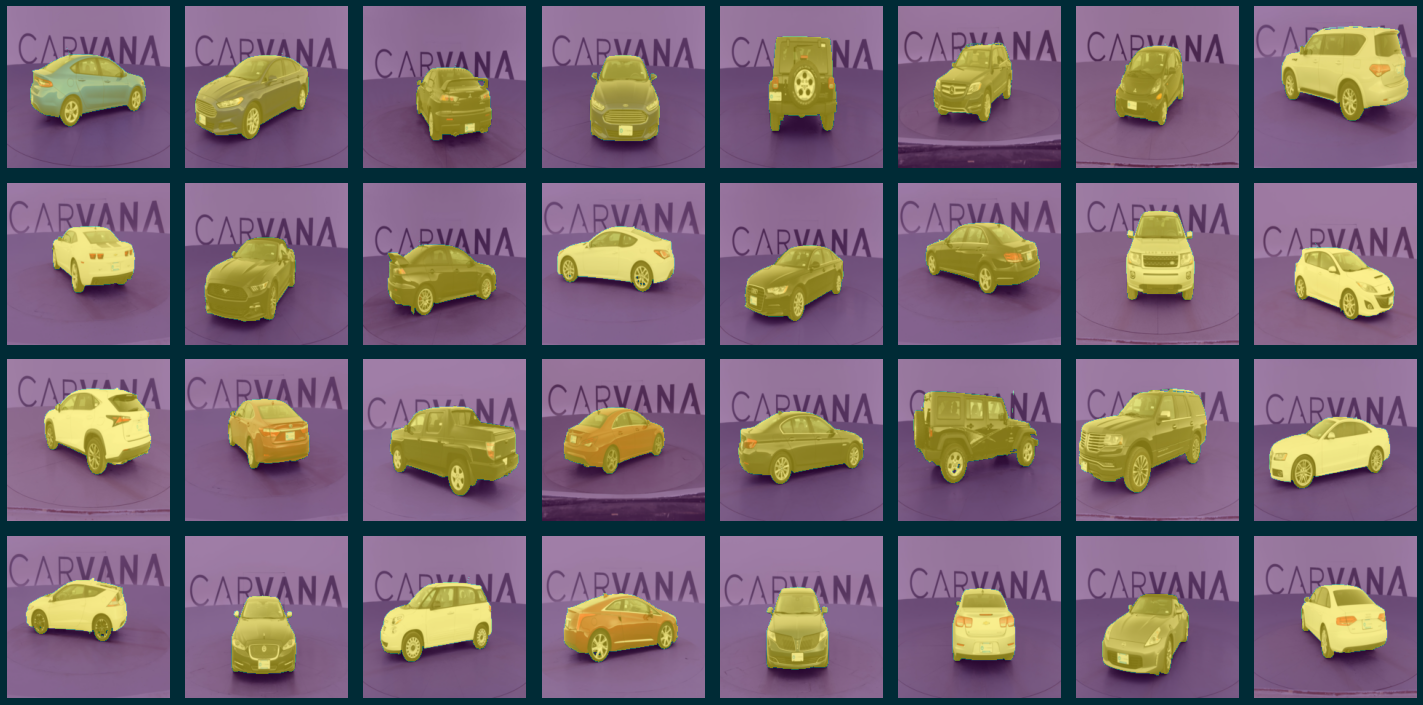

In [18]:
imgs, masks = next(iter(train_loader))
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4, 8, i+1)
        img=imgs[i,...].permute(1,2,0).numpy()
        mask = masks[i, ...].permute(1,2,0).numpy()
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)
        
        plt.axis('Off')
    plt.tight_layout()
    plt.show()

plot_mini_batch(imgs, masks)

### Accuracy

In [38]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)
            
        return cost/len(loader), float(correct)/total, dice, iou    

In [ ]:
len(train_loader)

#### Search for learning rate

In [39]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long).squeeze(1)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)
        
        preds = torch.argmax(scores, dim=1)
        acc_ = (preds == y).sum()/torch.numel(scores)
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
        
    return log_lrs, losses, accuracies     

### Train loop

In [66]:
def train(model, optimiser, scheduler = None, epochs = 100, store_every = 25):
    model = model.to(device=device)
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            
            if scheduler: 
                scheduler.step()
                
            train_predictions = torch.argmax(scores, dim=1)
            train_correct_num += (train_predictions == y).sum()
            train_total += torch.numel(train_predictions)
            train_cost_acum += cost.item()
            if mb%store_every == 0:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb
                print(f'epoch: {epoch}, mb: {mb}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                      f'dice: {dice}, iou: {iou}')
                    # Save data
                    #train_acc_history.append(train_acc)
                    #train_cost_history.append(train_cost_every)
        #train_acc = float(train_correct_num)/train_total
        #train_cost_every = float(train_cost_acum)/len(train_loader)
        # return train_acc_history ... etc    

### U-NET model

In [19]:
class Conv_3_k(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        return self.conv1(x)

In [32]:
class Double_Conv(nn.Module):
    '''
    Double convolution block for U-Net
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
                           Conv_3_k(channels_in, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
            
                           Conv_3_k(channels_out, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
                            )
    def forward(self, x):
        return self.double_conv(x)
    
class Down_Conv(nn.Module):
    '''
    Down convolution part
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
                        nn.MaxPool2d(2,2),
                        Double_Conv(channels_in, channels_out)
                        )
    def forward(self, x):
        return self.encoder(x)
    
class Up_Conv(nn.Module):
    '''
    Up convolution part
    '''
    def __init__(self,channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bicubic'),
                        nn.Conv2d(channels_in, channels_in//2, kernel_size=1, stride=1)
                        )
        self.decoder = Double_Conv(channels_in, channels_out)
    
    def forward(self, x1, x2):
        '''
        x1 - upsampled volume
        x2 - volume from down sample to concatenate
        '''
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1],dim=1)
        return self.decoder(x)
    
class UNET(nn.Module):
    '''
    UNET model
    '''
    def __init__(self, channels_in, channels, num_classes):
        super().__init__()
        self.first_conv = Double_Conv(channels_in, channels) #64, 224, 224
        self.down_conv1 = Down_Conv(channels, 2*channels) # 128, 112, 112
        self.down_conv2 = Down_Conv(2*channels, 4*channels) # 256, 56, 56
        self.down_conv3 = Down_Conv(4*channels, 8*channels) # 512, 28, 28
        
        self.middle_conv = Down_Conv(8*channels, 16*channels) # 1024, 14, 14 
        
        self.up_conv1 = Up_Conv(16*channels, 8*channels)
        self.up_conv2 = Up_Conv(8*channels, 4*channels)
        self.up_conv3 = Up_Conv(4*channels, 2*channels)
        self.up_conv4 = Up_Conv(2*channels, channels)
        
        self.last_conv = nn.Conv2d(channels, num_classes, kernel_size=1, stride=1)
        
    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)
        
        x5 = self.middle_conv(x4)
        
        u1 = self.up_conv1(x5, x4)
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)
        
        return self.last_conv(u4)
        

In [33]:
def test():
    x = torch.randn((32, 3, 224, 224))
    model = UNET(3, 64, 2)
    return model(x)

In [34]:
preds = test()

In [35]:
print(preds.shape)

torch.Size([32, 2, 224, 224])


### Train model

In [40]:
# define the model and look for learning rate
torch.manual_seed(42)
model = UNET(3, 4, 2)
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)

lg_lr, losses, accuracies = find_lr(model, optimiser_unet, start_val=1e-6, end_val=10)

cost:0.7952, lr: 0.0000, acc: 0.1971
cost:0.7980, lr: 0.0000, acc: 0.1965
cost:0.7996, lr: 0.0000, acc: 0.1930
cost:0.8069, lr: 0.0000, acc: 0.1837
cost:0.8080, lr: 0.0000, acc: 0.1855
cost:0.7971, lr: 0.0000, acc: 0.1969
cost:0.8014, lr: 0.0000, acc: 0.1913
cost:0.8033, lr: 0.0000, acc: 0.1889
cost:0.7919, lr: 0.0000, acc: 0.2008
cost:0.8034, lr: 0.0000, acc: 0.1889
cost:0.7984, lr: 0.0000, acc: 0.1969
cost:0.7903, lr: 0.0000, acc: 0.1971
cost:0.7948, lr: 0.0000, acc: 0.1954
cost:0.7986, lr: 0.0000, acc: 0.1925
cost:0.8014, lr: 0.0000, acc: 0.1945
cost:0.7887, lr: 0.0000, acc: 0.2019
cost:0.7997, lr: 0.0000, acc: 0.1947
cost:0.7950, lr: 0.0000, acc: 0.2006
cost:0.7863, lr: 0.0000, acc: 0.2064
cost:0.7944, lr: 0.0000, acc: 0.1973
cost:0.7893, lr: 0.0000, acc: 0.2028
cost:0.7962, lr: 0.0000, acc: 0.1964
cost:0.7993, lr: 0.0000, acc: 0.1913
cost:0.7984, lr: 0.0000, acc: 0.1922
cost:0.8084, lr: 0.0000, acc: 0.1833
cost:0.8006, lr: 0.0000, acc: 0.1891
cost:0.7869, lr: 0.0000, acc: 0.2053
c

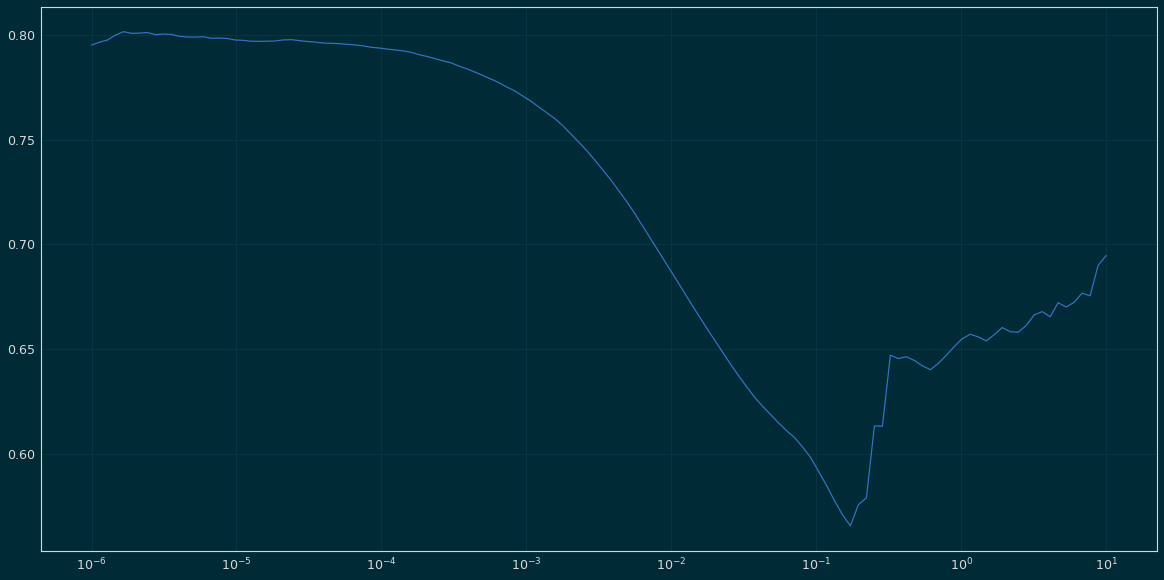

In [41]:
# plot loss vs learning rate
f1, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
plt.show()

In [77]:
# define the model and train with scheduler
torch.manual_seed(42)
model = UNET(3, 4, 2)
epochs = 5
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet, 
                                                max_lr = 1e-1,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [78]:
train(model, optimiser_unet, scheduler, epochs)

epoch: 0, mb: 25, train cost: 0.4948, val cost: 0.2781,train acc: 0.7312, val acc: 0.8760,dice: 0.6071811318397522, iou: 0.43593689799308777
epoch: 0, mb: 50, train cost: 0.3424, val cost: 0.1062,train acc: 0.8226, val acc: 0.9643,dice: 0.9164096713066101, iou: 0.8457159996032715
epoch: 0, mb: 75, train cost: 0.2523, val cost: 0.0559,train acc: 0.8728, val acc: 0.9797,dice: 0.951884388923645, iou: 0.9081863760948181
epoch: 0, mb: 100, train cost: 0.2014, val cost: 0.0443,train acc: 0.8999, val acc: 0.9823,dice: 0.9581198692321777, iou: 0.9196065664291382
epoch: 0, mb: 125, train cost: 0.1688, val cost: 0.0344,train acc: 0.9169, val acc: 0.9865,dice: 0.9680091738700867, iou: 0.9380016922950745
epoch: 1, mb: 25, train cost: 0.0316, val cost: 0.0300,train acc: 0.9875, val acc: 0.9882,dice: 0.9724186062812805, iou: 0.9463178515434265
epoch: 1, mb: 50, train cost: 0.0306, val cost: 0.0287,train acc: 0.9880, val acc: 0.9884,dice: 0.9727520942687988, iou: 0.9469496607780457
epoch: 1, mb: 75, 

### Plot some images

torch.Size([32, 224, 224])


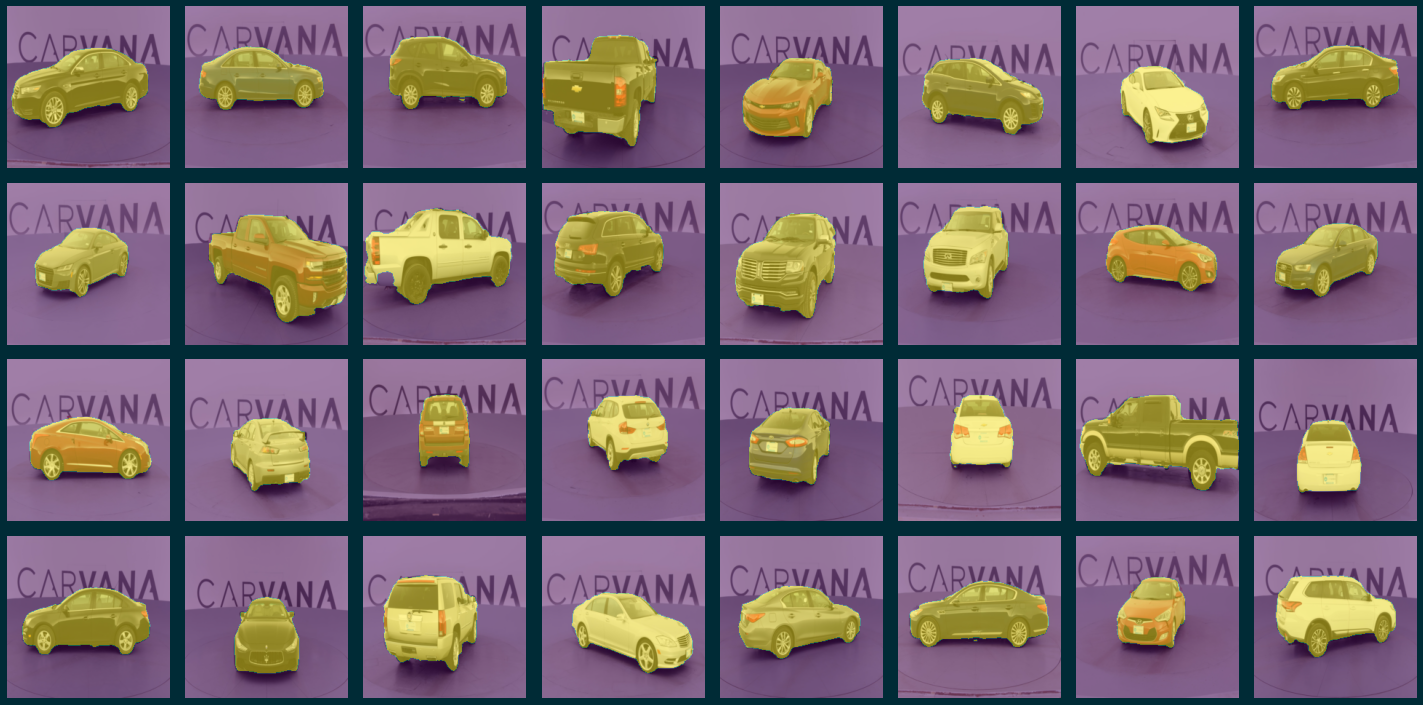

In [82]:
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))

In [73]:
test_set = Car_Dataset(TEST_PATH, img_transforms=transform_data)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([32, 224, 224])


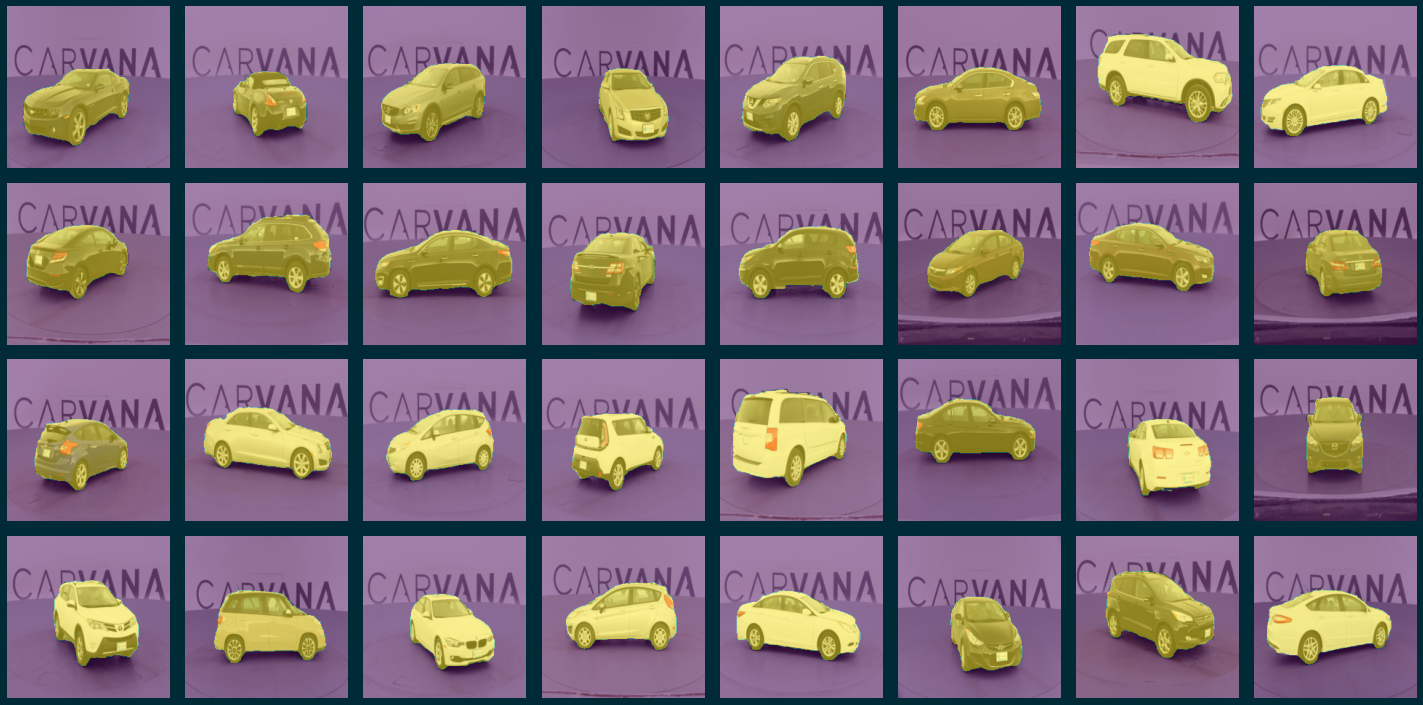

In [91]:
imgs_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()

imgs_test = imgs_test.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_test, preds.unsqueeze(1))